# Lab 4: Information theoretic key agreement
Laboratory session 4 of *Information Security*, AY 2024/25, team *pwnthemole3*.

In [ ]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Preparation: Channel and Encoder/Decoder Setup

In [ ]:
# --- Hamming Code ---
# Hamming (7,4) codewords
Hamming_words = [
    '0000000', '1000110', '0100101', '0010011',
    '0001111', '1100011', '1010101', '1001001',
    '0110110', '0101010', '0011100', '1110000',
    '1101100', '1011010', '0111001', '1111111'
]

# Hamming distance between two binary strings
def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

# Bitwise complement of a binary string
def bitwise_complement(word):
    return ''.join('1' if b == '0' else '0' for b in word)

# Generate all 3-bit messages
def generate_messages():
    return [format(i, '03b') for i in range(8)]

# Generate all 7-bit binary strings (used for Task 1)
def generate_all_7bit_words():
    return [format(i, '07b') for i in range(128)]

# --- Encoder --- for task 2
# Get bin: codeword with prefix 0+u and its complement
def get_bin(u):
    prefix = '0' + u
    for word in Hamming_words:
        if word.startswith(prefix):
            return [word, bitwise_complement(word)]
    return []

# Random binning encoder
def random_binning_encoder(u):
    return random.choice(get_bin(u))

# --- Channels ---
# Eavesdropper channel (flips up to 3 bits)
def eavesdropper_channel(x):
    x = list(x)
    for i in random.sample(range(7), random.randint(0, 3)):
        x[i] = '1' if x[i] == '0' else '0'
    return ''.join(x)

# Legitimate channel (flips 1 bit)
def legitimate_channel(x):
    x = list(x)
    i = random.randint(0, 6)
    x[i] = '1' if x[i] == '0' else '0'
    return ''.join(x)

# --- Decoder --- for task 3
# Decoder function
def decode(y):
    closest = min(Hamming_words, key=lambda w: hamming_distance(y, w))
    if closest[0] == '0':
        return closest[1:4]
    else:
        return bitwise_complement(closest[1:4])

# Generate sets of outputs within allowed Hamming distances
def Ty_given_x(a):
    return [b for b in generate_all_7bit_words() if hamming_distance(a, b) <= 1]

def Tz_given_x(a):
    return [c for c in generate_all_7bit_words() if hamming_distance(a, c) <= 3]

# Plot distribution
def plot_bar(counter, label, trials):
    probs = {k: v / trials for k, v in counter.items()}
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(probs)), list(probs.values()))
    plt.title(f"Empirical Distribution of {label}")
    plt.xlabel(label)
    plt.ylabel("Probability")
    plt.xticks(range(len(probs)), list(probs.keys()), rotation=90)
    plt.tight_layout()
    plt.show()

# Task 1

Simulate Uniform Error Wiretap Channel

\Simulate Uniform Error Wiretap Channel
Estimated mutual information I(Y; Z | X = 1001000) = 0.002999 bits


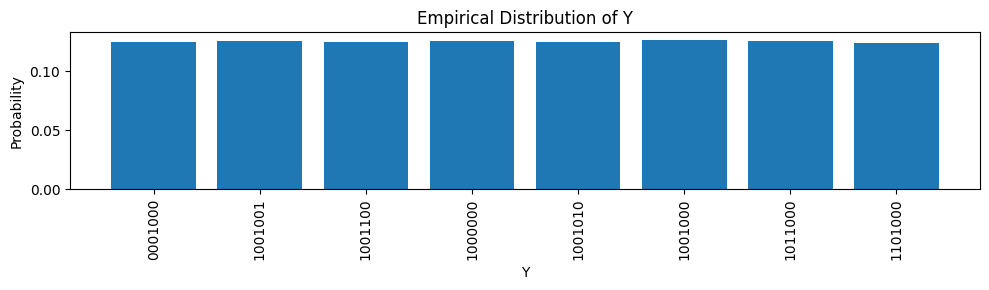

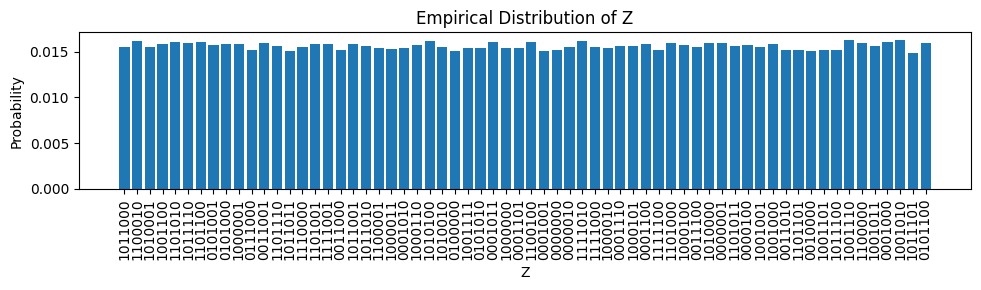

Std dev of P(Y|X): 0.000742
Std dev of P(Z|X): 0.000345
Y and Z appear conditionally independent given X.


In [ ]:
def task1(x='1001000', trials=100000):
    print("\Simulate Uniform Error Wiretap Channel")
    y_samples = []
    z_samples = []
    Ty = Ty_given_x(x)
    Tz = Tz_given_x(x)

    # Sample from conditional distributions
    for _ in range(trials):
        y = random.choice(Ty)
        z = random.choice(Tz)
        y_samples.append(y)
        z_samples.append(z)

    # Empirical mutual information I(Y;Z|X)
    joint_counts = Counter(zip(y_samples, z_samples))
    y_counts = Counter(y_samples)
    z_counts = Counter(z_samples)

    mi = 0.0
    for (y, z), count in joint_counts.items():
        p_yz = count / trials
        p_y = y_counts[y] / trials
        p_z = z_counts[z] / trials
        mi += p_yz * np.log2(p_yz / (p_y * p_z))

    print(f"Estimated mutual information I(Y; Z | X = {x}) = {mi:.6f} bits")

    plot_bar(y_counts, "Y", trials=trials)
    plot_bar(z_counts, "Z", trials=trials)

    # Print std dev of output probabilities to check uniformity
    y_probs = np.array([v / trials for v in y_counts.values()])
    z_probs = np.array([v / trials for v in z_counts.values()])

    print(f"Std dev of P(Y|X): {np.std(y_probs):.6f}")
    print(f"Std dev of P(Z|X): {np.std(z_probs):.6f}")

    # Check how close mutual information is to 0
    if mi < 0.01:
        print("Y and Z appear conditionally independent given X.")
    else:
        print("Y and Z may not be conditionally independent.")

task1()

In [ ]:
# Parity‐check matrix H for the (7,4) Hamming code
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])

def compute_syndrome(word: np.ndarray) -> np.ndarray:
    """
    Compute the 3‐bit syndrome H⋅word over GF(2).
    """
    return (H @ word) % 2

def correct_forward(received: np.ndarray, syndrome_alice: np.ndarray) -> np.ndarray:
    """
    Given a 7‐bit 'received' word and Alice's syndrome, recover the original codeword
    by locating the single‐bit error via the syndrome difference.
    """
    # Bob/Eve compute their own syndrome
    syn_recv = compute_syndrome(received)
    # The difference (in GF(2)) is the syndrome of the error vector
    err_synd = (syn_recv ^ syndrome_alice) % 2

    # If zero, no error
    if np.all(err_synd == 0):
        return received.copy()

    # Otherwise find which column of H matches that syndrome
    for j in range(H.shape[1]):
        if np.array_equal(H[:, j], err_synd):
            corrected = received.copy()
            corrected[j] ^= 1
            return corrected

    # Should never happen if at most one error
    raise ValueError("Unrecoverable error pattern")


# Task 2

Forward Reconciliation

In [ ]:
# 1) Pick an arbitrary 7-bit codeword x
x = np.array([1, 0, 0, 1, 0, 0, 0])

# 2) Simulate Bob’s and Eve’s channels: at most one bit flip
def flip_one(bitstring, pos):
    out = bitstring.copy()
    out[pos] ^= 1
    return out

# Test *all* single‐bit errors (and the no-error case)
print(" error_pos | Bob recovers | Eve recovers")
print("---------------------------------------")
for err_b in range(-1, 7):   # -1 means no error
    y = x.copy() if err_b<0 else flip_one(x, err_b)
    for err_e in [err_b]:    # you can also test different error for Eve
        z = x.copy() if err_e<0 else flip_one(x, err_e)

        # Alice’s syndrome
        c = compute_syndrome(x)

        x_hat_bob = correct_forward(y, c)
        x_hat_eve = correct_forward(z, c)

        print(f"    {err_b:2d}     |     {x_hat_bob.tolist()==x.tolist()}     |     {x_hat_eve.tolist()==x.tolist()}")

 error_pos | Bob recovers | Eve recovers
---------------------------------------
    -1     |     True     |     True
     0     |     True     |     True
     1     |     True     |     True
     2     |     True     |     True
     3     |     True     |     True
     4     |     True     |     True
     5     |     True     |     True
     6     |     True     |     True


# Task 3

Reverse Reconciliation

In [ ]:
# Original x
x = np.array([1, 0, 0, 1, 0, 0, 0])

# Simulate one‐bit errors on A→B and A→E independently
def flip_one(word, pos):
    w = word.copy()
    w[pos] ^= 1
    return w

print(" err_b | err_e | Alice recovers y | Eve recovers y?")
for err_b in range(-1, 7):      # -1 means no error on Bob’s branch
    y = x if err_b < 0 else flip_one(x, err_b)
    sB = compute_syndrome(y)    # Bob’s syndrome

    # Alice’s reconstruction of y
    y_hat_A = correct_forward(x, sB)

    for err_e in range(-1, 7):  # -1 means no error on Eve’s branch
        z = x if err_e < 0 else flip_one(x, err_e)
        # Eve tries the *same* correction
        y_hat_E = correct_forward(z, sB)

        okA = np.array_equal(y_hat_A, y)
        okE = np.array_equal(y_hat_E, y)
        print(f"  {err_b:2d}   |  {err_e:2d}   |      {okA}       |     {okE}")

 err_b | err_e | Alice recovers y | Eve recovers y?
  -1   |  -1   |      True       |     True
  -1   |   0   |      True       |     True
  -1   |   1   |      True       |     True
  -1   |   2   |      True       |     True
  -1   |   3   |      True       |     True
  -1   |   4   |      True       |     True
  -1   |   5   |      True       |     True
  -1   |   6   |      True       |     True
   0   |  -1   |      True       |     True
   0   |   0   |      True       |     True
   0   |   1   |      True       |     False
   0   |   2   |      True       |     False
   0   |   3   |      True       |     False
   0   |   4   |      True       |     False
   0   |   5   |      True       |     False
   0   |   6   |      True       |     False
   1   |  -1   |      True       |     True
   1   |   0   |      True       |     False
   1   |   1   |      True       |     True
   1   |   2   |      True       |     False
   1   |   3   |      True       |     False
   1   |   4   

## Task 4: Deterministic privacy amplification
Implement the deterministic privacy amplification with the matrix $A$:

$$ A = \left(\begin{array}{cccc|ccc}
1 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 1 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 \\
\end{array}\right)$$

and show that the result of $y′ = Ay$ is uniform and statistically independent from the syndrome $c$.

In [ ]:
# define privacy amplification matrix
A = np.array([[1, 0, 0, 0, 0, 0, 1],
              [0, 1, 0, 0, 1, 1, 0],
              [0, 0, 1, 0, 1, 0, 0],
              [0, 0, 0, 1, 1, 0, 0]])

# compute y'=Ay
def deterministicAmplification(y: np.ndarray) -> np.ndarray:
    """
    Compute key with privacy amplification matrix A  over GF(2).
    """
    return (A @ y) % 2

Simulate Uniform Error Wiretap Channel with deterministic privacy amplification
Estimated mutual information I(Y'; C) = 0.000709 bits


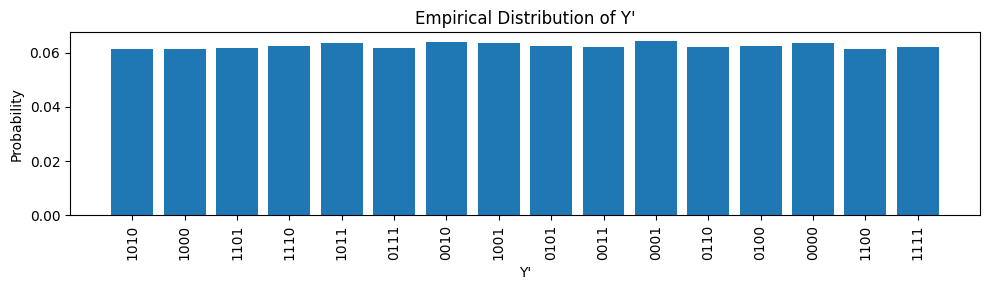

Std dev of P(Y'): 0.000948
Y' and C appear statistically independent.


In [ ]:
def task4(trials=100000):
    print("Simulate Uniform Error Wiretap Channel with deterministic privacy amplification")
    x_population = generate_all_7bit_words()
    x_vals = random.choices(x_population, k=trials)
    c_samples = []
    y_primes = []

    for x in x_vals:
        x_vec = np.array([int(b) for b in x])
        # compute syndrome
        c = compute_syndrome(x_vec)
        c_str = "".join(map(str, c))
        c_samples.append(c_str)
        # Generate sets of outputs within allowed Hamming distances
        Ty = Ty_given_x(x)
        Tz = Tz_given_x(x)
        # sample
        y = random.choice(Ty)
        z = random.choice(Tz)
        # convert to arrays of 0/1 integers
        y_vec = np.array([int(b) for b in y])
        z_vec = np.array([int(b) for b in z])
        # reconciliation (on Bob's side)
        y_hat = correct_forward(y_vec, c)
        # deterministic privacy amplification
        y_prime = deterministicAmplification(y_hat)
        y_primes.append("".join(map(str, y_prime)))

    # Empirical mutual information I(Y';C)
    joint_counts = Counter(zip(y_primes, c_samples))
    yp_counts = Counter(y_primes)
    c_counts = Counter(c_samples)
    mi = 0.0
    for (yp, c), count in joint_counts.items():
        p_yc = count / trials
        p_yp = yp_counts[yp] / trials
        p_c = c_counts[c] / trials
        mi += p_yc * np.log2(p_yc / (p_yp * p_c))

    print(f"Estimated mutual information I(Y'; C) = {mi:.6f} bits")
    plot_bar(yp_counts, "Y'", trials=trials)

    # Print std dev of output probabilities to check uniformity
    yp_probs = np.array([v / trials for v in yp_counts.values()])
    print(f"Std dev of P(Y'): {np.std(yp_probs):.6f}")

    # Check how close mutual information is to 0
    if mi < 0.01:
        print("Y' and C appear statistically independent.")
    else:
        print("Y' and C may not be statistically independent.")

task4()

## Task 5: Probabilitstic privacy amplification
Implement probabilistic privacy amplification with universal hashing on $y′$ from $\{0, 1\}^4$ to $\{0, 1\}^l$ for
$l = 1, 2, 3$. For what value of $l$ is the final key uniform and independent of $c$ and $z$?

In [ ]:
def generateHashmatr(m:int=4, l:int=1) -> np.ndarray:
    # generate binary matrix for universal hashing
    # it will later be applied to the keys as (M @ y)%2
    return np.array(random.choices([0, 1], k=m*l)).reshape((l,m))


Simulate Uniform Error Wiretap Channel with probabilistic privacy amplification

l=1
Estimated mutual information I(Y''; C) = 0.000090 bits
Estimated mutual information I(Y''; Z) = 0.005373 bits


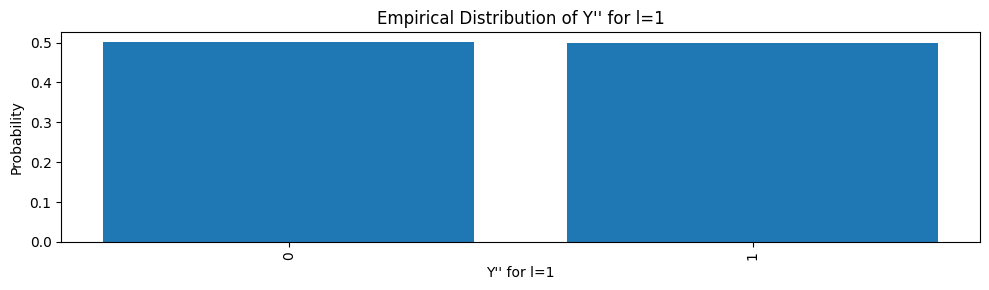

Std dev of P(Y''): 0.000760
Y'' and C appear statistically independent.
Y'' and Z appear statistically independent.

l=2
Estimated mutual information I(Y''; C) = 0.000292 bits
Estimated mutual information I(Y''; Z) = 0.010665 bits


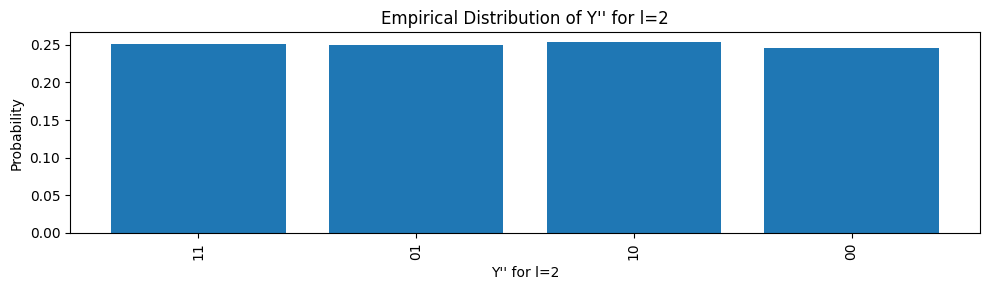

Std dev of P(Y''): 0.002948
Y'' and C appear statistically independent.
Y'' and Z may not be statistically independent.

l=3
Estimated mutual information I(Y''; C) = 0.000188 bits
Estimated mutual information I(Y''; Z) = 0.005478 bits


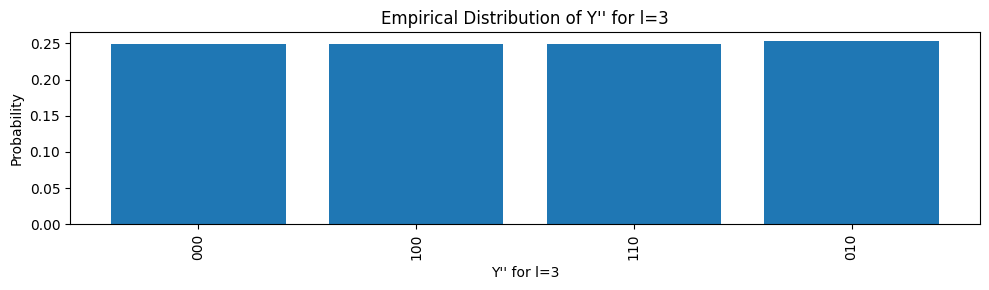

Std dev of P(Y''): 0.001592
Y'' and C appear statistically independent.
Y'' and Z appear statistically independent.


In [ ]:
def task5(trials=50000):
    print("Simulate Uniform Error Wiretap Channel with probabilistic privacy amplification")
    x_population = generate_all_7bit_words()
    l_vals = [1, 2, 3]
    for l in l_vals:
        print(f"\nl={l}")
        # generate x words for testing
        x_vals = random.choices(x_population, k=trials)
        c_samples = []
        z_samples = []
        y_pps = []

        # generate random hashmatrix M to be used in this session
        M = generateHashmatr(4, l)

        for x in x_vals:
            x_vec = np.array([int(b) for b in x])
            # compute syndrome
            c = compute_syndrome(x_vec)
            c_str = "".join(map(str, c))
            c_samples.append(c_str)
            # Generate sets of outputs within allowed Hamming distances
            Ty = Ty_given_x(x)
            Tz = Tz_given_x(x)
            # sample
            y = random.choice(Ty)
            z = random.choice(Tz)
            z_samples.append(z)
            # convert to arrays of 0/1 integers
            y_vec = np.array([int(b) for b in y])
            # reconciliation (on Bob's side)
            y_hat = correct_forward(y_vec, c)
            # deterministic privacy amplification
            y_prime = deterministicAmplification(y_hat)
            # generate random Hash matrix
            #M = generateHashmatr(len(y_prime), l)
            # probabilistic privacy amplification
            y_pp = (M @ y_prime) % 2
            y_pps.append("".join(map(str, y_pp)))

        # Empirical mutual information
        joint_counts_c = Counter(zip(y_pps, c_samples))
        joint_counts_z = Counter(zip(y_pps, z_samples))
        ypp_counts = Counter(y_pps)
        c_counts = Counter(c_samples)
        z_counts = Counter(z_samples)
        # Empirical mutual information I(Y''; C)
        mi_c = 0.0
        for (ypp, c), count in joint_counts_c.items():
            p_yc = count / trials
            p_ypp = ypp_counts[ypp] / trials
            p_c = c_counts[c] / trials
            mi_c += p_yc * np.log2(p_yc / (p_ypp * p_c))

        # Empirical mutual information I(Y''; Z)
        mi_z = 0.0
        for (ypp, z), count in joint_counts_z.items():
            p_yz = count / trials
            p_ypp = ypp_counts[ypp] / trials
            p_z = z_counts[z] / trials
            mi_z += p_yz * np.log2(p_yz / (p_ypp * p_z))

        print(f"Estimated mutual information I(Y''; C) = {mi_c:.6f} bits")
        print(f"Estimated mutual information I(Y''; Z) = {mi_z:.6f} bits")

        plot_bar(ypp_counts, f"Y'' for l={l}", trials=trials)

        # Print std dev of output probabilities to check uniformity
        ypp_probs = np.array([v / trials for v in ypp_counts.values()])
        print(f"Std dev of P(Y''): {np.std(ypp_probs):.6f}")

        # Check how close mutual information is to 0
        if mi_c < 0.01:
            print("Y'' and C appear statistically independent.")
        else:
            print("Y'' and C may not be statistically independent.")

        if mi_z < 0.01:
            print("Y'' and Z appear statistically independent.")
        else:
            print("Y'' and Z may not be statistically independent.")

task5()

# Task 6

(Bob error rate): 0.1, (Eve error rate): 0.3, (key length): 2
Average bit errors per block (Bob): 0.71 (10.16%)
Average bit errors per block (Eve): 2.10 (30.03%)
Final key mismatch rate (P[kA not equal kB]): 0.0850
Standard deviation of error pattern frequencies: 0.010741
Total unique error patterns: 127


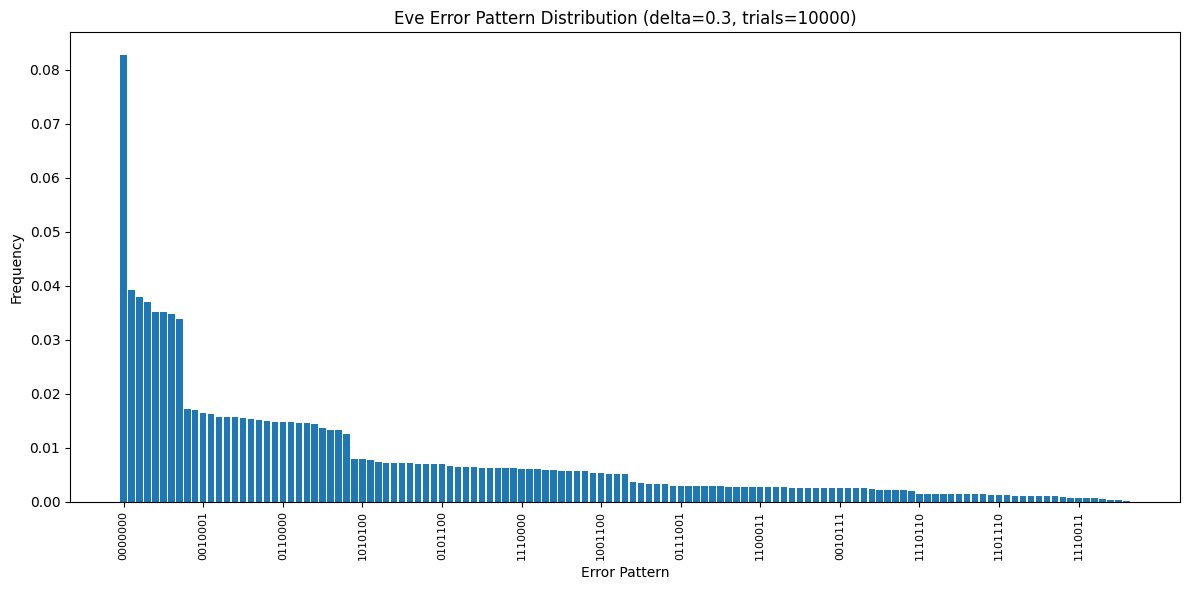

In [ ]:
def bsc_channel(x, error_prob):
    noise = np.random.rand(len(x)) < error_prob
    return (x ^ noise.astype(int)) % 2

def full_pipeline_bsc(epsilon=0.1, delta=0.2, l=2, trials=10000):
    bit_length = 7
    mismatches = 0
    errors_bob = 0
    errors_eve = 0

    M = generateHashmatr(4, l)

    for _ in range(trials):
        x = np.random.randint(0, 2, bit_length)
        y = bsc_channel(x, epsilon)
        z = bsc_channel(x, delta)

        errors_bob += np.sum(x != y)
        errors_eve += np.sum(x != z)

        sB = compute_syndrome(y)
        x_hat = correct_forward(x, sB)

        kA_intermediate = deterministicAmplification(x_hat)
        kB_intermediate = deterministicAmplification(y)

        kA = (M @ kA_intermediate) % 2
        kB = (M @ kB_intermediate) % 2

        if not np.array_equal(kA, kB):
            mismatches += 1

    avg_errors_bob = errors_bob / trials
    avg_errors_eve = errors_eve / trials
    mismatch_rate = mismatches / trials

    print(f"(Bob error rate): {epsilon}, (Eve error rate): {delta}, (key length): {l}")
    print(f"Average bit errors per block (Bob): {avg_errors_bob:.2f} ({avg_errors_bob/7:.2%})")
    print(f"Average bit errors per block (Eve): {avg_errors_eve:.2f} ({avg_errors_eve/7:.2%})")
    print(f"Final key mismatch rate (P[kA not equal kB]): {mismatch_rate:.4f}")

    return mismatch_rate

def analyze_eve_error_patterns(epsilon=0.1, delta=0.3, trials=10000, top_n=10):
    bit_length = 7
    error_patterns = Counter()

    for _ in range(trials):
        x = np.random.randint(0, 2, bit_length)
        z = bsc_channel(x, delta)

        error = (x ^ z).astype(int)
        error_str = ''.join(map(str, error))
        error_patterns[error_str] += 1

    sorted_patterns = error_patterns.most_common()
    patterns = [p for p, _ in sorted_patterns]
    counts = [c for _, c in sorted_patterns]

    frequencies = np.array(counts) / trials
    std_dev = np.std(frequencies)


    print(f"Standard deviation of error pattern frequencies: {std_dev:.6f}")
    print(f"Total unique error patterns: {len(error_patterns)}")

    # Plot o
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(frequencies)), frequencies)
    plt.xticks(
        [i for i in range(len(frequencies)) if i % 10 == 0],
        [patterns[i] for i in range(len(frequencies)) if i % 10 == 0],
        rotation=90,
        fontsize=8     )
    plt.xlabel("Error Pattern")
    plt.ylabel("Frequency")
    plt.title(f"Eve Error Pattern Distribution (delta={delta}, trials={trials})")
    plt.tight_layout()
    plt.show()



full_pipeline_bsc(epsilon=0.1, delta=0.3, l=2, trials=10000)
analyze_eve_error_patterns(epsilon=0.1, delta=0.3, trials=10000)


# Task 7


In [ ]:
import numpy as np
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

# Parameters
epsilon = 0.1
delta = 0.3
ell_values = [1, 2, 3]
n_trials = 10000
bit_length = 128
block_size = 7
n_blocks = bit_length // block_size

# Hamming (7,4) parity-check matrix
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])

def bsc_channel(x, p_error):
    noise = (np.random.rand(len(x)) < p_error).astype(int)
    return (x + noise) % 2

def hamming_syndrome_decode(received, H):
    syndrome = H.dot(received) % 2
    syndrome_table = {
        (0,0,1): [0,0,0,0,0,0,1],
        (0,1,0): [0,0,0,0,0,1,0],
        (1,0,0): [0,0,0,0,1,0,0],
        (0,1,1): [0,0,0,1,0,0,0],
        (1,1,0): [0,0,1,0,0,0,0],
        (1,0,1): [0,1,0,0,0,0,0],
        (1,1,1): [1,0,0,0,0,0,0]
    }
    correction = np.array(syndrome_table.get(tuple(syndrome), np.zeros(7)))
    return (received + correction) % 2

A_matrix = np.random.randint(0, 2, (4, 7))  # 4x7 random binary matrix

def deterministic_amplification(y_block, A_matrix):
    return (A_matrix @ y_block) % 2

def random_toeplitz_matrix(n, m):
    toeplitz_col = np.random.randint(0, 2, n + m - 1)
    return np.array([toeplitz_col[i:i+n] for i in range(m)])

def binary_entropy(bitstrings):
    counts = Counter(bitstrings)
    probs = np.array(list(counts.values())) / len(bitstrings)
    return entropy(probs, base=2)

def bitwise_mutual_info(keys, eves_info):
    n_bits = min(len(k) for k in keys)
    mi = 0.0
    for i in range(n_bits):
        key_bits = [k[i] for k in keys]
        eve_bits = [e[i % len(e)] for e in eves_info]
        mi += mutual_info_score(key_bits, eve_bits)
    return mi / n_bits

# MAIN LOOP over ell
for ell in ell_values:
    keys_A, keys_B, zc_pairs = [], [], []
    mismatches = 0

    for _ in range(n_trials):
        x = np.random.randint(0, 2, bit_length)
        blocks_A, blocks_B, blocks_zc = [], [], []

        for b in range(n_blocks):
            x_block = x[b * block_size : (b + 1) * block_size]
            y_block = bsc_channel(x_block, epsilon)
            z_block = bsc_channel(x_block, delta)

            c_block = H.dot(y_block) % 2
            y_hat_block = hamming_syndrome_decode(y_block, H)

            # Deterministic privacy amplification (7 -> 4 bits)
            y_amp_block = deterministic_amplification(y_hat_block, A_matrix)
            x_amp_block = deterministic_amplification(x_block, A_matrix)

            # Probabilistic privacy amplification (4 -> ell bits)
            T_block = random_toeplitz_matrix(4, ell)
            kA_block = T_block.dot(x_amp_block) % 2
            kB_block = T_block.dot(y_amp_block) % 2

            blocks_A.append(''.join(map(str, kA_block)))
            blocks_B.append(''.join(map(str, kB_block)))
            blocks_zc.append(''.join(map(str, z_block)) + ''.join(map(str, c_block)))

        final_kA = ''.join(blocks_A)
        final_kB = ''.join(blocks_B)
        final_zc = ''.join(blocks_zc)

        keys_A.append(final_kA)
        keys_B.append(final_kB)
        zc_pairs.append(final_zc)

        if final_kA != final_kB:
            mismatches += 1

    # Metrics
    mismatch_rate = mismatches / n_trials
    H_kA = binary_entropy(keys_A)
    H_kB = binary_entropy(keys_B)
    mi_kA_zc = bitwise_mutual_info(keys_A, zc_pairs)
    mi_kB_zc = bitwise_mutual_info(keys_B, zc_pairs)

    print(f"ℓ = {ell}")
    print(f"Key mismatch rate: {mismatch_rate:.4f}")
    print(f"Entropy H(kA): {H_kA:.4f}")
    print(f"Entropy H(kB): {H_kB:.4f}")
    print(f"Mutual information I(kA; z, c): {mi_kA_zc:.4f}")
    print(f"Mutual information I(kB; z, c): {mi_kB_zc:.4f}")
    print("-----------------------------")
